## Day 12

# Part 1

- the 2D height map displays heights as a-z where a is the low end
- The starting point is denoted as `S` and has height `a`
- the end point is denoted as `E` and has height `z`
- can move 1 step each time but the elevation of the next step must be <= 1 more than the current space

`What is the fewest steps required to move from your current position to the location that should get the best signal?`

In [1]:
from matplotlib import pyplot as plt
from utils import parse_from_file, ParseConfig

parser = ParseConfig('\n', ParseConfig('', str))

letter_grid = parse_from_file('day_12.txt', parser)

In [2]:
def get_start_end_points(letter_grid: 'list[list[str]]') -> tuple:
    """
    retuns (row, col), (row, col) for the start and end points resp.
    """
    S, E = None, None
    for row_num, row in enumerate(letter_grid):
        for col_num, letter in enumerate(row):
            if letter == 'S':
                S = row_num, col_num
                if (not S is None) and (not E is None):
                    return S, E
            if letter == 'E':
                E = row_num, col_num
                if (not S is None) and (not E is None):
                    return S, E

start, end = get_start_end_points(letter_grid)

print(f'start at {start} and end at {end}')

start at (20, 0) and end at (20, 139)


note that the y axis is flipped because the first row parsed is index 0


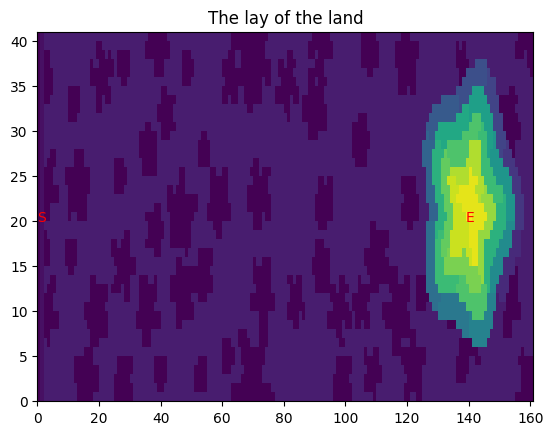

In [3]:
def letter_to_height(letter: str) -> int:
    """
    converts a letter to it's integer height value.

    Additionally S = 1 and E = 26
    """
    if letter == 'S':
        return 1
    elif letter == 'E':
        return 26
    else:
        return (ord(letter) - ord('a')) + 1

def convert_to_num(letter_grid: 'list[list[str]]') -> list[list[int]]:
    """
    returns a copy of the grid passed with letters converted to integers
    """
    int_grid = []
    for row in letter_grid:
        int_grid.append([letter_to_height(letter) for letter in row])
    return int_grid

int_grid = convert_to_num(letter_grid)

fig, ax = plt.subplots()
ax.pcolormesh(int_grid)
ax.set_title('The lay of the land')
ax.text(start[1], start[0], 'S', color='r')
ax.text(end[1], end[0], 'E', color='r')
print('note that the y axis is flipped because the first row parsed is index 0')

In [4]:
# let's get a net of the map so it's easier to run algorithms on it
net = {}
for row_num, row in enumerate(int_grid):
    for col_num, value in enumerate(row):
        connections = list()
        for row_off, col_off in [(1, 0), (-1, 0), (0, 1), (0, -1)]:
            r, c = row_num + row_off, col_num + col_off
            if (not 0 <= r < len(int_grid)) or (not 0 <= c < len(row)):
                continue
            if int_grid[r][c] > value + 1:
                continue
            connections.append((r, c))
        net.update({(row_num, col_num): connections})

print(f'{str(net)[:100]}...')

{(0, 0): [(1, 0), (0, 1)], (0, 1): [(1, 1), (0, 2), (0, 0)], (0, 2): [(1, 2), (0, 3), (0, 1)], (0, 3...


Text(139, 20, 'E')

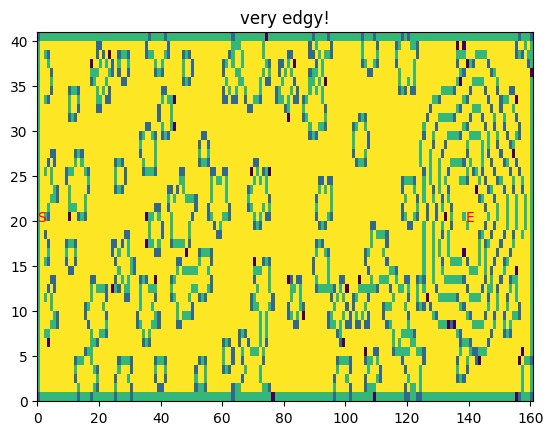

In [5]:
adjacent_nodes = [[0 for _ in row] for row in int_grid]
for (row, col), neighbours in net.items():
    adjacent_nodes[row][col] = len(neighbours)

fig, ax = plt.subplots()
ax.pcolormesh(adjacent_nodes)
ax.set_title('very edgy!')
ax.text(start[1], start[0], 'S', color='r')
ax.text(end[1], end[0], 'E', color='r')

In [6]:
# let's try Dijkstra's algorithm
def dijkstra(
        net: dict, start: tuple[int], end: tuple[int],
        end_condition: callable = None
) -> 'list[list[int]]':
    """
    run Djikstra's algorithm to find the shortest distance from start to end
    """
    # mark all nodes as unvisited
    visited = [[False for _ in row] for row in int_grid]

    # set all notes to a tentative max distance from start
    max_distance = len(int_grid) * len(int_grid[0])
    distances = [[max_distance for _ in row] for row in int_grid]
    # ...except for our starting node which is 0s
    r, c = start
    distances[r][c] = 0

    # set current node as the start
    current_node = start

    number_visited = 0
    while True:
        if number_visited % 100 == 0:
            percent_done = 100 * number_visited / max_distance
            print(f'{current_node} - {percent_done:.1f}%' + ' '*10, end='\r')

        r, c = current_node
        # iterate through each neighbour and set it's new tentative distance
        distance_to_here = distances[r][c]
        for neighbour in net[current_node]:
            r, c = neighbour
            if visited[r][c]:
                continue
            distances[r][c] = min(distances[r][c], distance_to_here + 1)

        r, c = current_node
        # mark this node as visited
        visited[r][c] = True
        number_visited += 1

        # if this node is the end, we're done!
        if current_node == end:
            return distances
        
        # otherwise find the node with the smallest tenative distance and
        # repeat
        u_r, u_c = None, None
        lowest_unvisited = max_distance
        for r, row in enumerate(visited):
            for c, is_visited in enumerate(row):
                if is_visited:
                    continue
                if distances[r][c] < lowest_unvisited:
                    u_r, u_c = r, c
                    lowest_unvisited = distances[r][c]
        if lowest_unvisited == max_distance:
            return distances
        current_node = (u_r, u_c)

dijkstra_distances = dijkstra(net, start, end)

Text(139, 20, 'E')

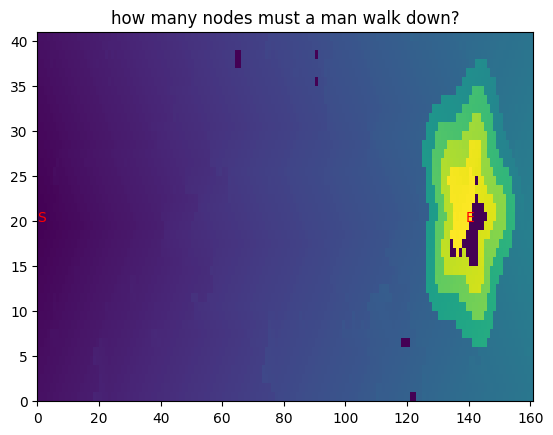

In [7]:
# some values are still set to max so let's set them to zero so they don't
# completely dominate the plot colour scale
plotable = [
    [value if value != 6601 else 0 for value in row]
    for row in dijkstra_distances
]
fig, ax = plt.subplots()
ax.pcolormesh(plotable)
ax.set_title('how many nodes must a man walk down?')
ax.text(start[1], start[0], 'S', color='r')
ax.text(end[1], end[0], 'E', color='r')

In [8]:
print(
    'the shortest distance from start to end is: '
    f'{dijkstra_distances[end[0]][end[1]]}!'
)

the shortest distance from start to end is: 481!


## Part 2

- let's make it more scenic!
- start point must be at level `a` (=1)
- find the start point with the shortest path to `E`

`What is the fewest steps required to move starting from any square with elevation a to the location that should get the best signal?`

Text(0.5, 1.0, 'the low points of the journey')

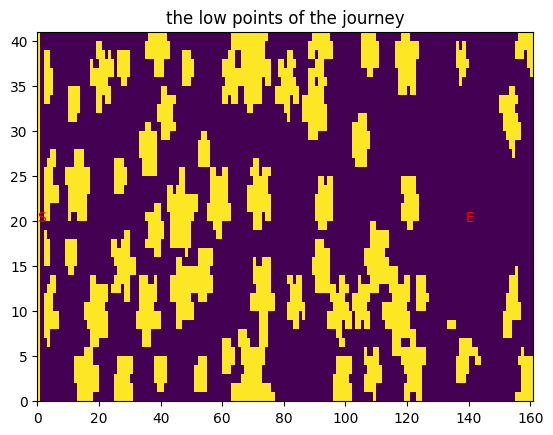

In [9]:
# here's all the places we could start our hike trail from
plotable = [[value == 1 for value in row] for row in int_grid]
fig, ax = plt.subplots()
ax.pcolormesh(plotable)
ax.text(start[1], start[0], 'S', color='r')
ax.text(end[1], end[0], 'E', color='r')
ax.set_title('the low points of the journey')

In [10]:
# could iterate through all points that start at 1 height buuut we can also
# start from E instead and find the closest point that of height 1

# to do this we need to create an inverted net because in the original we're
# allowed to slide down by any drop which would make it very easy to reach
# level a
inverted_net = {}
for row_num, row in enumerate(int_grid):
    for col_num, value in enumerate(row):
        connections = list()
        for row_off, col_off in [(1, 0), (-1, 0), (0, 1), (0, -1)]:
            r, c = row_num + row_off, col_num + col_off
            if (not 0 <= r < len(int_grid)) or (not 0 <= c < len(row)):
                continue
            if int_grid[r][c] < value - 1:
                continue
            connections.append((r, c))
        inverted_net.update({(row_num, col_num): connections})

print(f'{str(inverted_net)[:100]}...')

{(0, 0): [(1, 0), (0, 1)], (0, 1): [(1, 1), (0, 2), (0, 0)], (0, 2): [(1, 2), (0, 3), (0, 1)], (0, 3...


In [11]:
dijkstra_trail = dijkstra(inverted_net, end, None)    

Text(0.5, 1.0, 'how many nodes must an elf walk down... for a fun hike?')

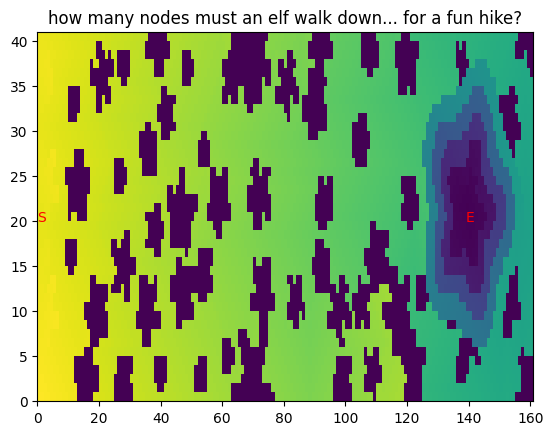

In [12]:
# some values are still set to max so let's set them to zero so they don't
# completely dominate the plot colour scale
plotable = [
    [value if value != 6601 else 0 for value in row]
    for row in dijkstra_trail
]
fig, ax = plt.subplots()
ax.pcolormesh(plotable)
ax.text(start[1], start[0], 'S', color='r')
ax.text(end[1], end[0], 'E', color='r')
ax.set_title('how many nodes must an elf walk down... for a fun hike?')

In [14]:
trail_length = min([
    min([distance for c, distance in enumerate(row) if int_grid[r][c] == 1])
    for r, row in enumerate(dijkstra_trail)
])

print('shortest distance from level a to point E is: 'f'{trail_length}!')

shortest distance from level a to point E is: 480!
